In [1]:
import sys
sys.path.append("..")

import numpy as np
import torch
from matplotlib import pyplot as plt
from inflation import  BBI
import time
import json
from numpy import arange

from utils_synthetic import *

from mpl_toolkits.mplot3d import Axes3D

import sys
#!{sys.executable} -m pip install hyperopt
!mkdir -p results
from hyperopt import hp, tpe, Trials, fmin
from hyperopt.pyll.base import scope 

In [2]:
n=10
i_vec = torch.arange(1,n+1)
print(i_vec)

device = 'cpu'

def zakharov(xs):
    return torch.sum(xs**2)+  (0.5*torch.sum(i_vec*xs))**2+(0.5*torch.sum(i_vec*xs))**4

    
global_min = torch.zeros(n)
print(zakharov(global_min))


xs = torch.tensor([1., 1., 1., 1., 1.,1.,1.,1.,1.,1.])
print("Initial value: ", zakharov(xs).item())

tensor([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10])
tensor(0.)
Initial value:  572680.3125


In [3]:
#The hyperopt tuning function
potential = zakharov

def hyperopt_tuning(ranges, ranges_integer, optimizer, tune_iterations=1000, n_trials=100, **fixed_pars):
  
    def optimizer_func(pars):
        xs = optimizer(x0, potential, iterations=tune_iterations, **pars, **fixed_pars)
        return potential(xs).item()

    fspace = {}
    for par, range in ranges.items(): fspace[par] = hp.uniform(par, *range)
    for par, range in ranges_integer.items(): fspace[par] = scope.int(hp.uniform(par, *range))

    trials = Trials()
    best = fmin(fn=optimizer_func, space=fspace, algo=tpe.suggest, trials=trials, max_evals=n_trials)
    return best

In [4]:
#common parameters
tune_iterations = 2500 
n_trials = 500 
test_iterations = 4*tune_iterations

x0 =xs.tolist()

In [5]:
#sgd

best_par_sgd = hyperopt_tuning({'lr': [1e-10,.5], 'momentum': [0,1.0]},{}, sgd_optimizer, tune_iterations=tune_iterations, n_trials=n_trials)
print("sgd:", best_par_sgd)

with open('sgd-param-zakharov.txt', 'w') as filehandle:
    json.dump( best_par_sgd, filehandle)



100%|██████████████| 500/500 [04:02<00:00,  2.06trial/s, best loss: 572680.3125]
sgd: {'lr': 0.19114345172342317, 'momentum': 0.44921232158009416}


In [6]:
#since it is not converging, we restrict the lr range. - The result is ok since the determined lr is not at the edge of the interval


best_par_sgd = hyperopt_tuning({'lr': [1e-10,1e-5], 'momentum': [0,1.0]},{}, sgd_optimizer, tune_iterations=tune_iterations, n_trials=n_trials)
print("sgd:", best_par_sgd)


with open('sgd-param-zakharov.txt', 'w') as filehandle:
    json.dump( best_par_sgd, filehandle)



100%|███| 500/500 [03:57<00:00,  2.11trial/s, best loss: 0.00011591961811063811]
sgd: {'lr': 1.8026609877941198e-06, 'momentum': 0.99722657760598}


In [7]:
#sgd - gamma (tuning on -log of momentum) - it's not better

best_par_sgd_gamma = hyperopt_tuning({'lr': [1e-10,1e-5], 'gamma': [0,10000000000]},{}, sgd_optimizer_gamma, tune_iterations=tune_iterations, n_trials=n_trials)
print("sgd gamma:", best_par_sgd_gamma)


with open('sgd-gamma-param-zakharov.txt', 'w') as filehandle:
    json.dump( best_par_sgd, filehandle)


100%|████████| 500/500 [03:49<00:00,  2.18trial/s, best loss: 2.001640796661377]
sgd gamma: {'gamma': 8447992045.079048, 'lr': 6.852263790671208e-06}


In [8]:
##BBI

#turning off bounces
threshold0 = 1e20
n_fixed_bounces = 0
threshold = 1e25
v0 = 1e-22
consEn = True
deltaEn = 0.0


best_par_BBI = hyperopt_tuning({'lr': [1e-6,1e-2]},{}, BBI_optimizer, tune_iterations=tune_iterations,  n_trials=n_trials,
    threshold0 = threshold0,threshold = threshold, deltaEn = deltaEn, v0 = v0,  n_fixed_bounces = n_fixed_bounces , consEn = consEn)


best_par_BBI['deltaEn'] = deltaEn
best_par_BBI['v0'] = v0
best_par_BBI['threshold0'] = threshold0
best_par_BBI['threshold'] = threshold
best_par_BBI['n_fixed_bounces'] = n_fixed_bounces
best_par_BBI['consEn'] = True


print("BBI:", best_par_BBI)

with open('bbi-param-zakharov.txt', 'w') as filehandle:
    json.dump( best_par_BBI, filehandle)



100%|███| 500/500 [04:14<00:00,  1.96trial/s, best loss: 1.0791815170395526e-17]
BBI: {'lr': 0.0026036721489343054, 'deltaEn': 0.0, 'v0': 1e-22, 'threshold0': 1e+20, 'threshold': 1e+25, 'n_fixed_bounces': 0, 'consEn': True}


Final loss:  9.999785112489005e-23


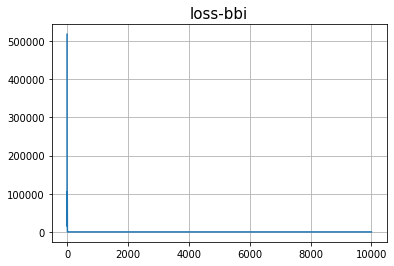

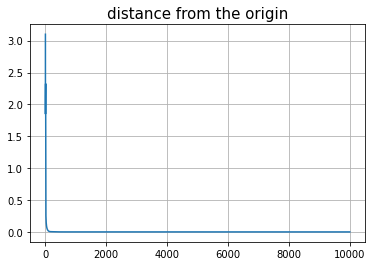

In [9]:
x0 =xs.tolist()
xs_list_BBI = BBI_optimizer_fullhistory(x0, potential, iterations=test_iterations, **best_par_BBI)

min_temp = 10e20
for elem in xs_list_BBI:
    elem_tens_val  = zakharov(torch.tensor(elem))
    if elem_tens_val < min_temp:
        min_temp = elem_tens_val.item()
min_BBI = min_temp

print("Final loss: ", min_BBI )
plotting(zakharov, xs_list_BBI, "loss-bbi")
plotting(distance, xs_list_BBI, "distance from the origin")

Final loss:  4.438572339532376e-12


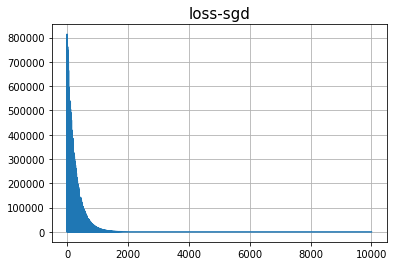

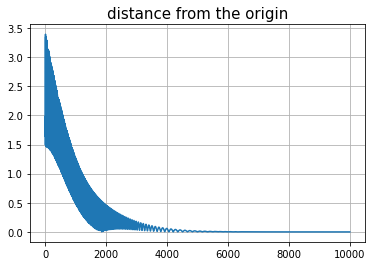

In [10]:
#sgd

x0 =xs.tolist()
xslist_sgd = sgd_optimizer_fullhistory(x0, potential, iterations=test_iterations, **best_par_sgd )

min_temp = 10e20
for elem in xslist_sgd:
    elem_tens_val  = zakharov(torch.tensor(elem))
    if elem_tens_val < min_temp:
        min_temp = elem_tens_val.item()

min_sgd = min_temp
print("Final loss: ", min_sgd )
plotting(zakharov, xslist_sgd, "loss-sgd")
plotting(distance, xslist_sgd, "distance from the origin")

Final loss:  1.6291362047195435


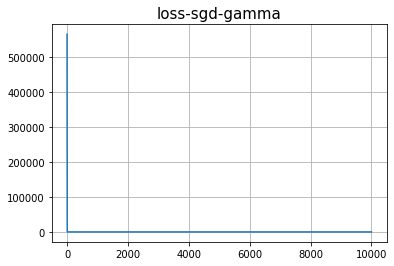

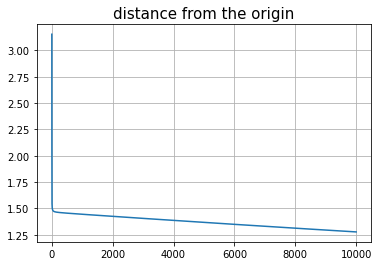

In [11]:
#sgd-gamma
#nchecks > 1 is useful for non-deterministic algorithms

x0 =xs.tolist()
xslist_sgd_gamma = sgd_optimizer_gamma_fullhistory(x0, potential, iterations=test_iterations, **best_par_sgd_gamma )

min_temp = 10e20
for elem in xslist_sgd_gamma:
    elem_tens_val  = zakharov(torch.tensor(elem))
    if elem_tens_val < min_temp:
        min_temp = elem_tens_val.item()

min_sgd_gamma = min_temp

print("Final loss: ", min_sgd_gamma )
plotting(zakharov, xslist_sgd_gamma, "loss-sgd-gamma")
plotting(distance, xslist_sgd_gamma, "distance from the origin")

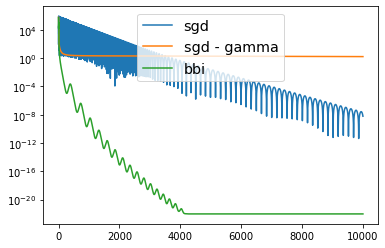

In [12]:
losses_sgd = []
for elem in xslist_sgd: losses_sgd.append(zakharov(torch.tensor(elem)))

losses_sgd_gamma = []
for elem in xslist_sgd_gamma: losses_sgd_gamma.append(zakharov(torch.tensor(elem)))

losses_bbi = []
for elem in xs_list_BBI: losses_bbi.append(zakharov(torch.tensor(elem)))

plt.plot(losses_sgd, label="sgd")
plt.plot(losses_sgd_gamma, label="sgd - gamma")
plt.plot(losses_bbi, label="bbi")
plt.yscale('log')
plt.legend(loc='upper center', shadow=False, fontsize='x-large')

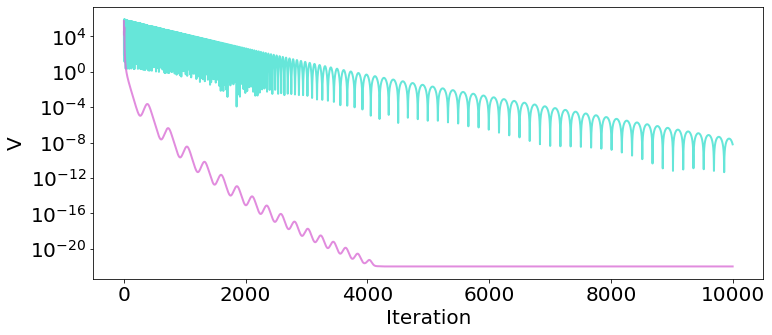

In [13]:
plt.figure(figsize=(12, 5))
plt.plot(losses_sgd, label="GDM", alpha=.8, linewidth=2, color='turquoise')
plt.plot(losses_bbi, label="BBI", alpha = .8, linewidth=2, color='orchid')

plt.xlabel('Iteration', fontsize = 20)
plt.ylabel('V', fontsize = 20)
plt.yscale('log')
#plt.legend(loc='best', shadow=False, fontsize='x-large')
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)

plt.savefig('hyperopt-zakharov.pdf',bbox_inches='tight')
